In [135]:
import pandas as pd
import numpy as np
import mnist

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(0)

## Load the dataset

The MNIST database is available at http://yann.lecun.com/exdb/mnist/

The MNIST database is a dataset of handwritten digits. It has 60,000 training samples, and 10,000 test samples. Each image is represented by 28x28 pixels, each containing a value 0 - 255 with its grayscale value.

We will be using the `mnist` library to download images and labels from the MNIST database

The dataset is downloaded and cached in your temporary directory, so, calling the functions again, is much faster and doesn't hit the server.

In [2]:
import mnist

train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [3]:
print(f'train images shape: {train_images.shape}')
print(f'test images shape: {test_images.shape}')

train images shape: (60000, 28, 28)
test images shape: (10000, 28, 28)


## MNIST Images and labels

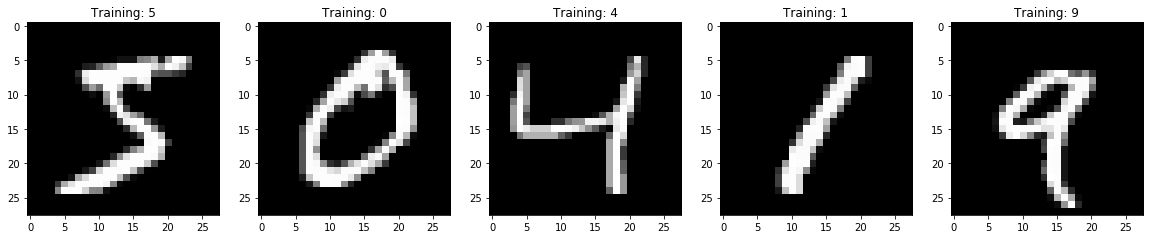

In [4]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(train_images[:5], train_labels[:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title(f'Training: {label}')

## Training and prediction using Logistic Regression

In [70]:
# Flatten images since the algorithm expects a 2d array

# move to utils.py
def flatten_images(images):
    n_samples, x_pixels, y_pixels = images.shape
    return images.reshape(n_samples, x_pixels*y_pixels)
    
train_data = flatten_images(train_images)
test_data = flatten_images(test_images)

# Scale data using minmax scaler, as it is more suited for images.
min_max_scaler = preprocessing.MinMaxScaler()
train_min_max = min_max_scaler.fit_transform(train_data)
test_min_max = min_max_scaler.transform(test_data)

In [88]:
# move to utils.py
def print_classification_vector(coef):
    # Pick max value from the co-efficient matrix
    scale = np.abs(coef).max()
    
    plt.figure(figsize=(20, 10))
    for i in range(coef.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(coef[i].reshape(28,28), interpolation='nearest',
                       cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)

### Baseline model

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Sparsity of the matrix: 8.545918367346939
Accuracy score: 0.926
Classification vectors.. None
Wall time: 3min 19s


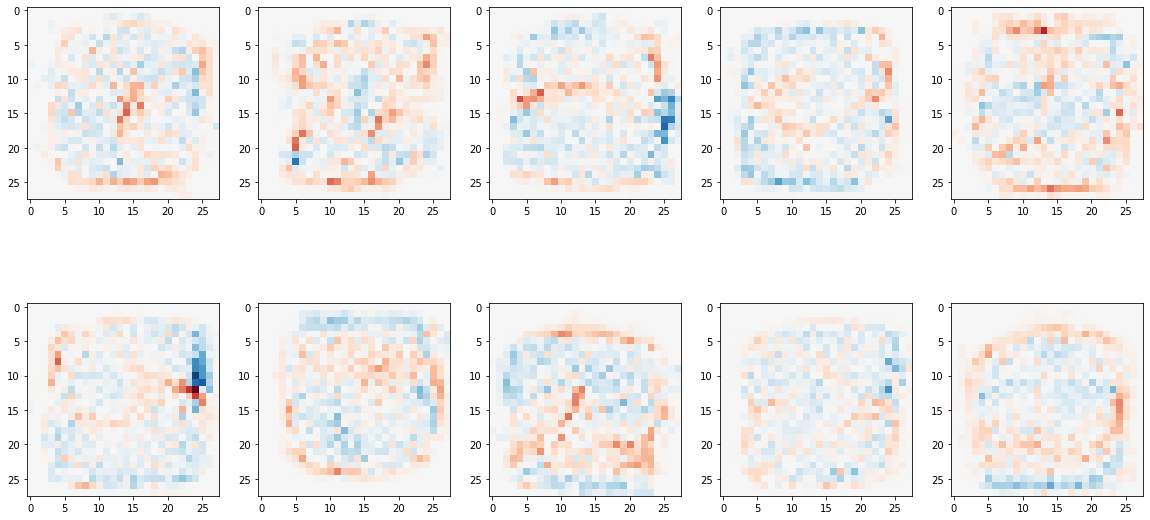

In [89]:
%%time

# Saga is chosen as the optimization algorithm as it is suitable for multiclass problems

clf = LogisticRegression(solver='saga')
clf.fit(train_min_max, train_labels)

predictions = clf.predict(test_min_max)

score = accuracy_score(test_labels, predictions)
sparsity = np.mean(clf.coef_ == 0) * 100

print(f'Sparsity of the matrix: {sparsity}')
print(f'Accuracy score: {score}')
print(f'Classification vectors.. {print_classification_vector(clf.coef_.copy())}')

In [90]:
# Final weights of the digit zero
# clf.coef_[1]

It is a little surprising to see that a model that does not converge has an accuracy of 92.6%. The the classification vectors are not sparse, this tells us that the model might be generalizing a lot. Let us make sure the model converges and see how those classification vectors differ

### Improvements to Baseline: version 1

In this version, let us use tolerance for faster convergence and use L1 regularization to increase sparsity.

Sparsity of the matrix: 73.06122448979592
Accuracy score with l1 penalty: 0.8939
Classification vectors.. None
Wall time: 15.3 s


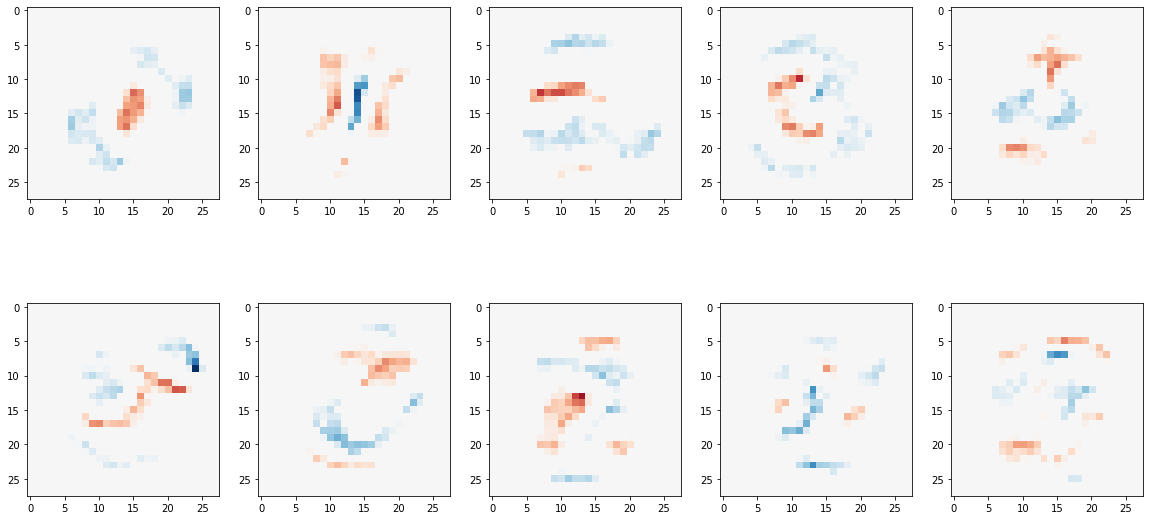

In [94]:
%%time

# Saga is chosen as the optimization algorithm as it is suitable for multiclass problems
# Turn up tolerance for faster convergence.
# Use l1 to increase the sparsity of the matrix, which helps in better classification

clf = LogisticRegression(C = 0.01, solver='saga', tol=0.1, penalty='l1')
clf.fit(train_min_max, train_labels)

predictions = clf.predict(test_min_max)

score = accuracy_score(test_labels, predictions)
sparsity = np.mean(clf.coef_ == 0) * 100

print(f'Sparsity of the matrix: {sparsity}')
print(f'Accuracy score with l1 penalty: {score}')
print(f'Classification vectors.. {print_classification_vector(clf.coef_.copy())}')

We can see a huge improvement in the performance. The total-time taken to run the model has dropped to 15s from 3min 19s. Adding tolerence seems to have made the difference. Sparsity of the classification vectors has increased as well, which helps in better recognition of digits. Let us explore the confusion matrix to see if we can get some insights on the behaviour of our model.

## Confusion Matrix

In [158]:
# move to utils.py

def get_insights_from_confusion_matrix(confusion_matrix):
    n = 2
    print(confusion_matrix)
    
    for i, row in enumerate(confusion_matrix):
        row[i] = 0 # Assign 0 so that the current image is not considered as wrongly predicted (Stupid hack).
        top_misclassifications = row.argsort()[-3:][::-1]  # Get 2 highest values from array and reverse
        print(f'Majority of the images for {i} are wrongly predicted as {top_misclassifications}')
        

get_insights_from_confusion_matrix(confusion_matrix(test_labels, predictions))

[[ 951    1    4    0    0    9    9    2    3    1]
 [   0 1100    4    4    0    2    4    2   19    0]
 [  10   17  890   14   21    0   16   24   30   10]
 [   5    1   21  894    0   39    5   14   20   11]
 [   2    6    3    1  882    3   15    3   10   57]
 [  18    4    3   48   17  729   28   13   22   10]
 [  11    5    6    1   17   22  884    4    8    0]
 [   5   19   26    3    8    1    0  930    4   32]
 [   6   24    8   22   12   33   24   11  809   25]
 [  10   10    5   14   53   14    1   20   12  870]]
Majority of the images for 0 are wrongly predicted as [6 5 2]
Majority of the images for 1 are wrongly predicted as [8 6 3]
Majority of the images for 2 are wrongly predicted as [8 7 4]
Majority of the images for 3 are wrongly predicted as [5 2 8]
Majority of the images for 4 are wrongly predicted as [9 6 8]
Majority of the images for 5 are wrongly predicted as [3 6 8]
Majority of the images for 6 are wrongly predicted as [5 4 0]
Majority of the images for 7 are wr

They don't seem to follow any specific pattern apart from the fact that numbers that resemble same patterns are misclassified.

## Testing output for sanity check

Let us do a sanity check to see how the images look for both correctly classified and misclassified predictions and see if we can uncover more from the samples.

In [97]:
# Getting indexes for both misclassified and correctly classified images

index = 0
misclassified_images = []
correctly_classified_images = []

for label, predict in zip(test_labels, predictions):
    if label == predict:
        correctly_classified_images.append(index)
    else:
        misclassified_images.append(index)
    index += 1

### Display correctly classified images

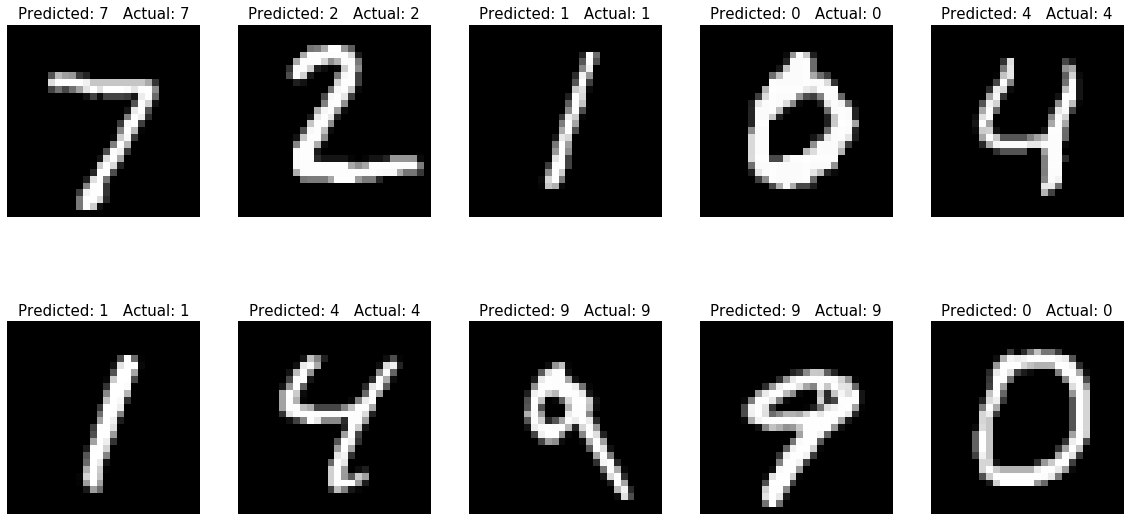

In [98]:
plt.figure(figsize=(20, 10))

for i, correctly_classified_index in enumerate(zip(correctly_classified_images[: 10])):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.reshape(test_data[correctly_classified_index], (28, 28)), cmap=plt.cm.gray)
    plt.title(f'Predicted: {predictions[correctly_classified_index]}   Actual: {test_labels[correctly_classified_index]}', 
              fontsize = 15)
    plt.axis('off')


From the above list, we can make out that the images that were correctly classified have a clear distinction,not too blurry. The model also identified few numbers that were slanting. For example: the number 9 in the last row.

### Display misclassified images

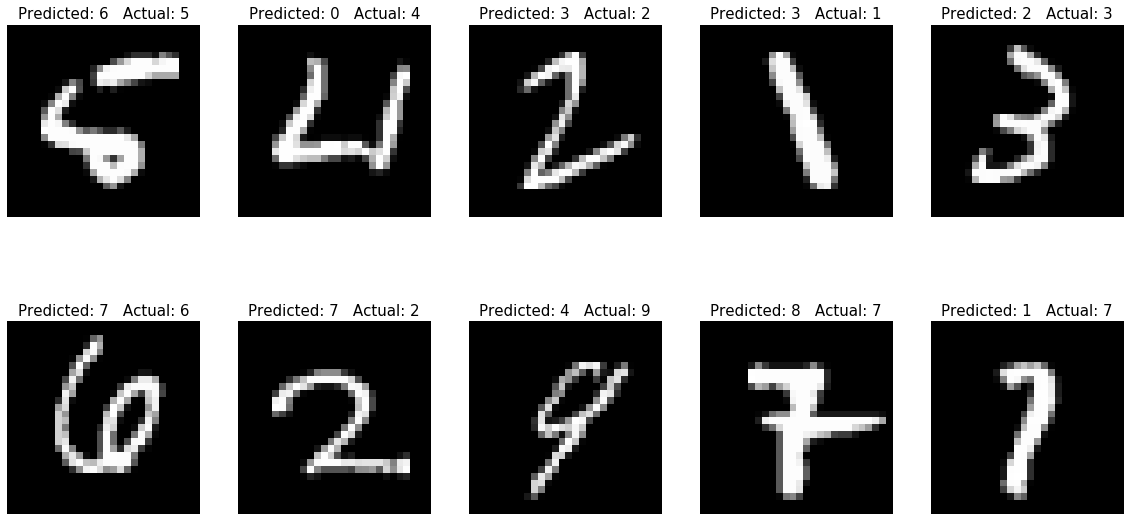

In [159]:
plt.figure(figsize=(20, 10))

i = 0
for misclassified_images_index in (misclassified_images[0:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(test_data[misclassified_images_index], (28, 28)), cmap=plt.cm.gray)
    plt.title(f'Predicted: {predictions[misclassified_images_index]}   Actual: {test_labels[misclassified_images_index]}', 
              fontsize = 15)
    plt.axis('off')
    i += 1

From the above, we can notice that most of the incorrectly classified digits are hand written, some numbers do not have clear shapes and are blurry. Let us see how the model is misclassifying for each digit.

#### Misclassified images for the digit 1

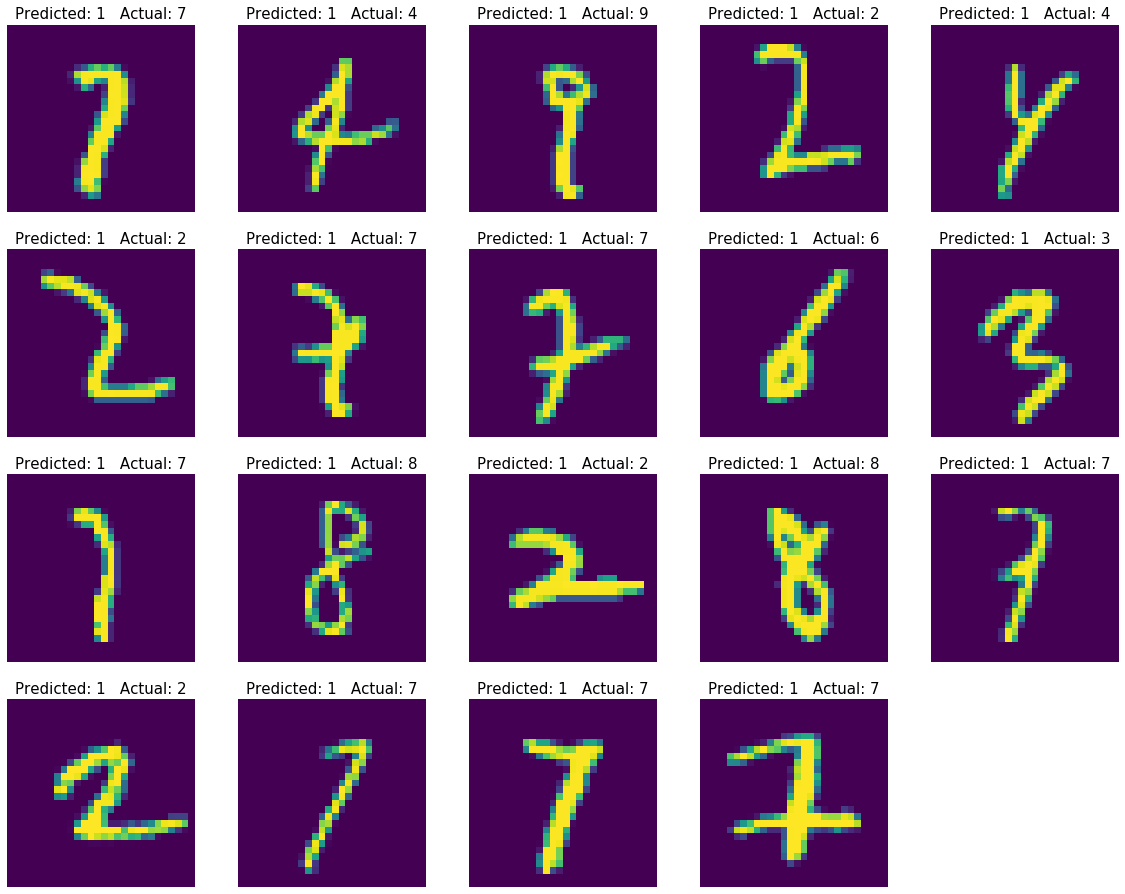

In [163]:
# A method that displays a list of misclassified images for a given number

def show_image(i, image_index):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(test_data[image_index], (28, 28)), cmap=plt.cm.gray)
    plt.title(f'Predicted: {predictions[image_index]}   Actual: {test_labels[image_index]}', 
              fontsize = 15)
    plt.axis('off')

# Displays images for a given number. 
# For ex: if 6 is passed as num, the method displays all images that were predicted as 6 
def display_images_for_number(predicted_list, num):
    plt.figure(figsize=(20, 20))

    i = 0
    for predicted_index in (predicted_list):
        if predictions[predicted_index] == num:
            show_image(i, predicted_index)
            i += 1
            
           
display_images_for_number(misclassified_images[0:250], 1)

Most of the images misclassified as 1 seem to have a  clear straight line

#### Misclassified images for the digit 2

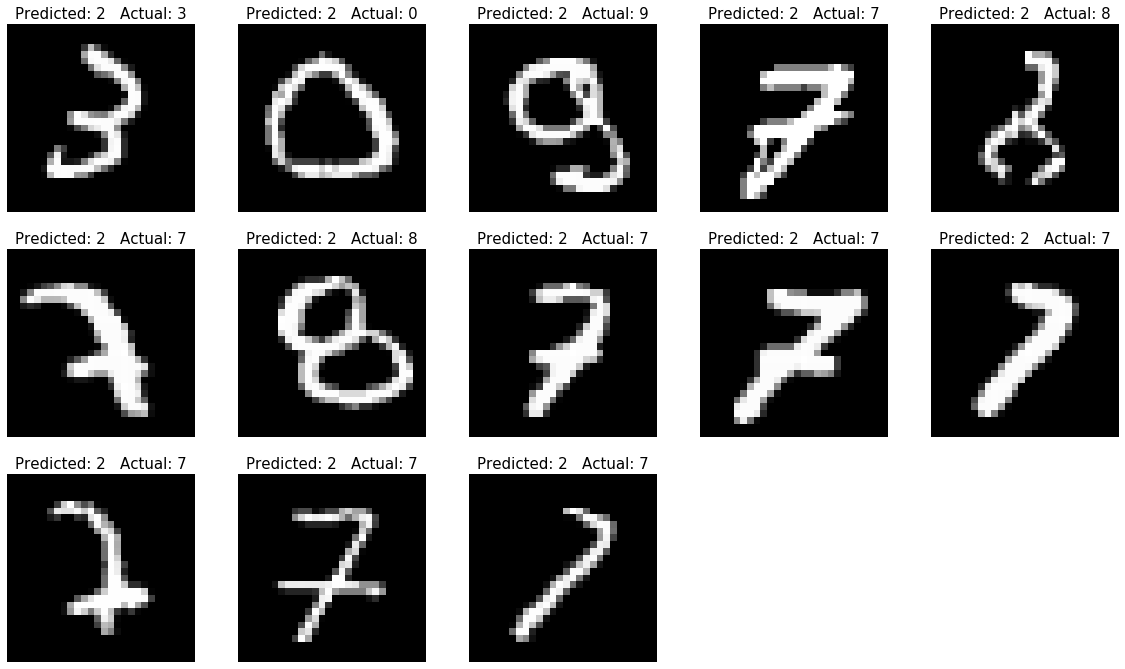

In [160]:
display_images_for_number(misclassified_images[0:200], 2)

A lot of 7's seem to be misclassified as 2

#### Misclassified images for the digit 3

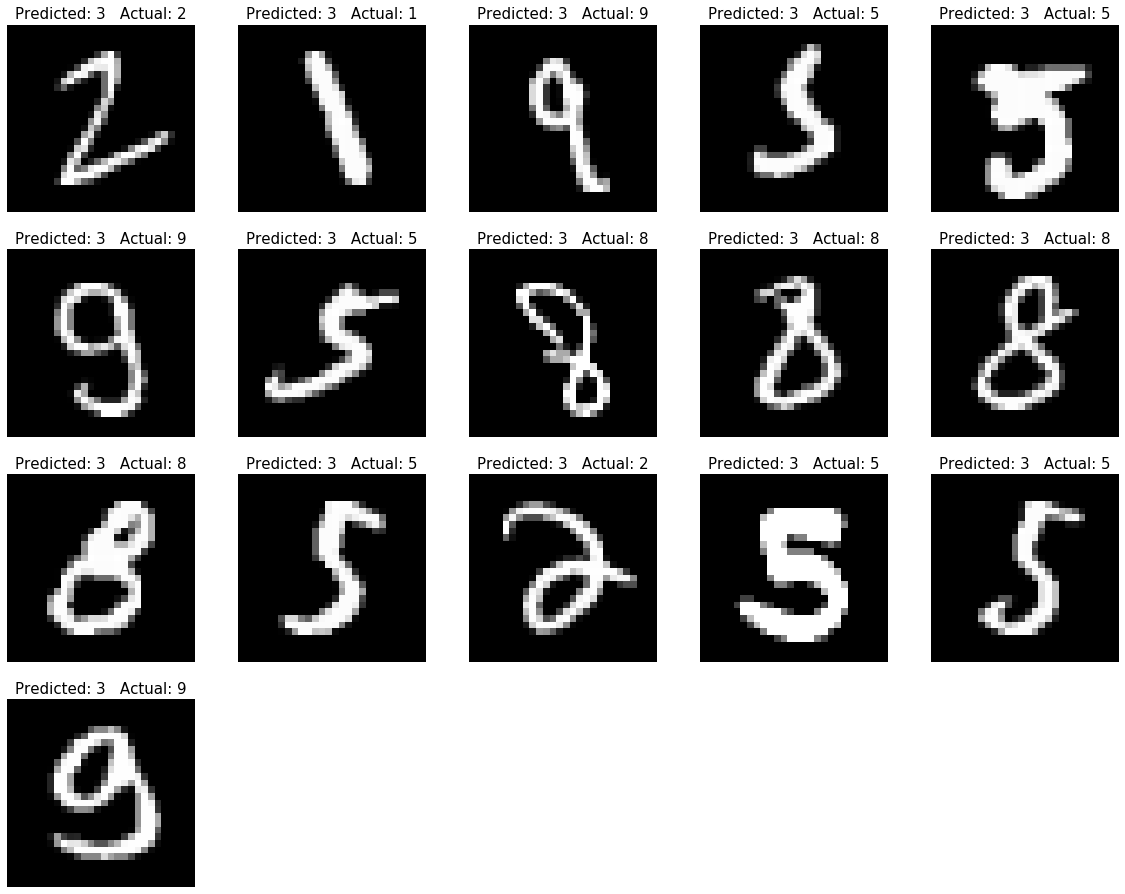

In [161]:
display_images_for_number(misclassified_images[0:150], 3)

No pattern other than slant and closely resembling images getting misclassified.

#### Misclassified images for the digit 4

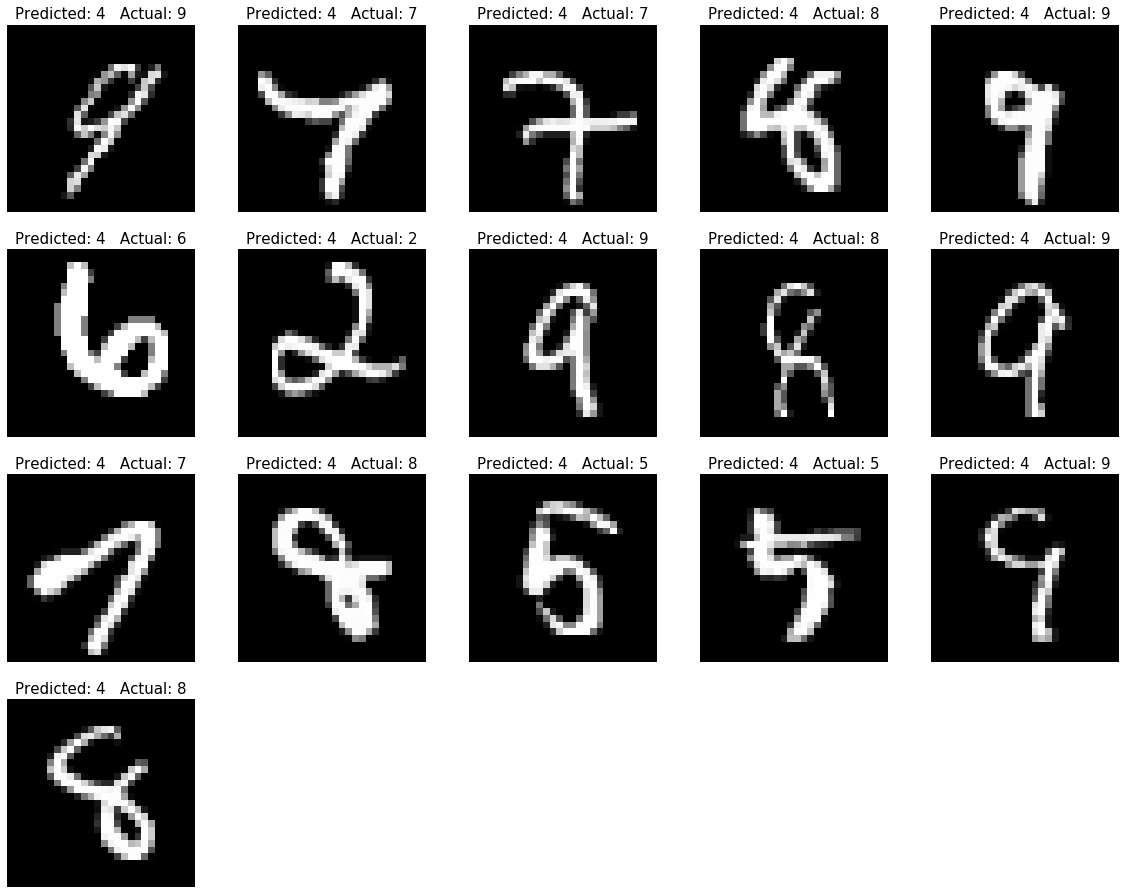

In [102]:
display_images_for_number(misclassified_images[0:150], 4)

No pattern other than slant, unclear and closely resembling images getting misclassified.

#### Misclassified images for the digit 5

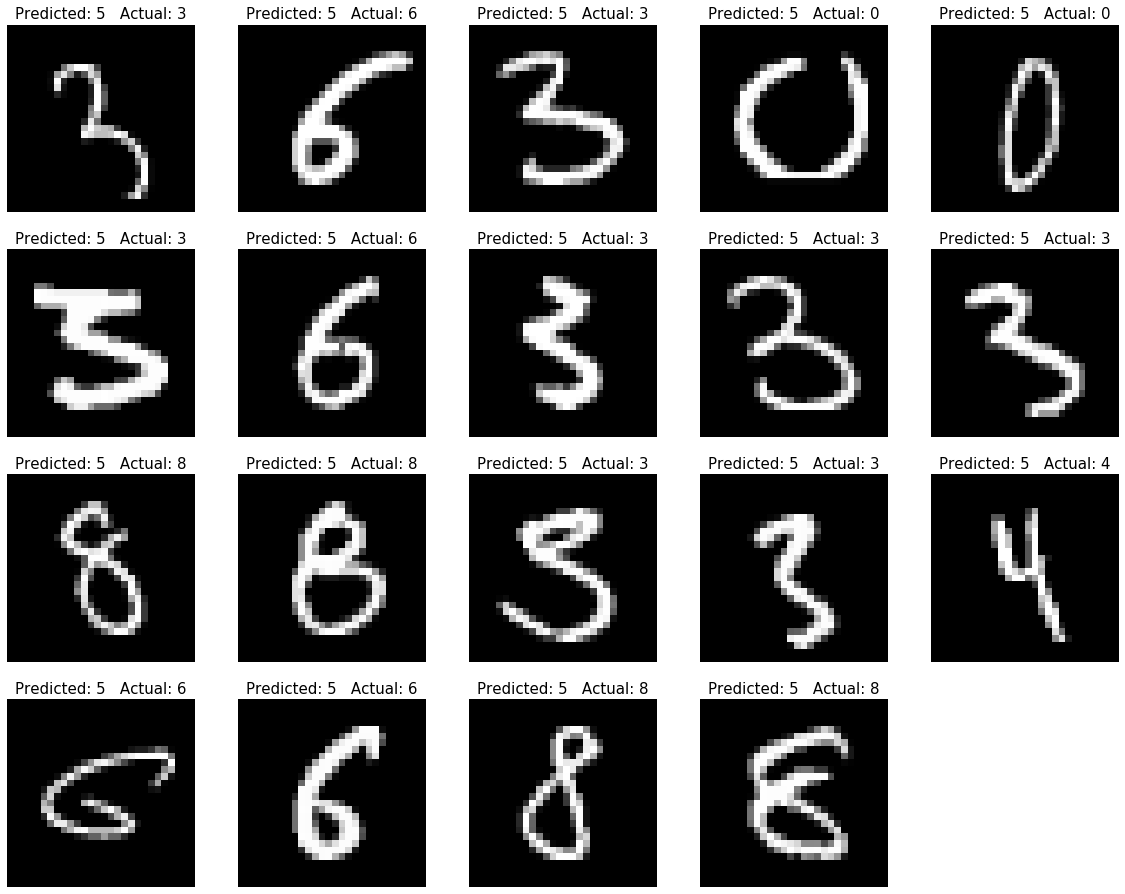

In [162]:
display_images_for_number(misclassified_images[0:150], 5)

The numbers seem to resemble the pattern 5 and also some are not very clear.

#### Misclassified images for the digit 6

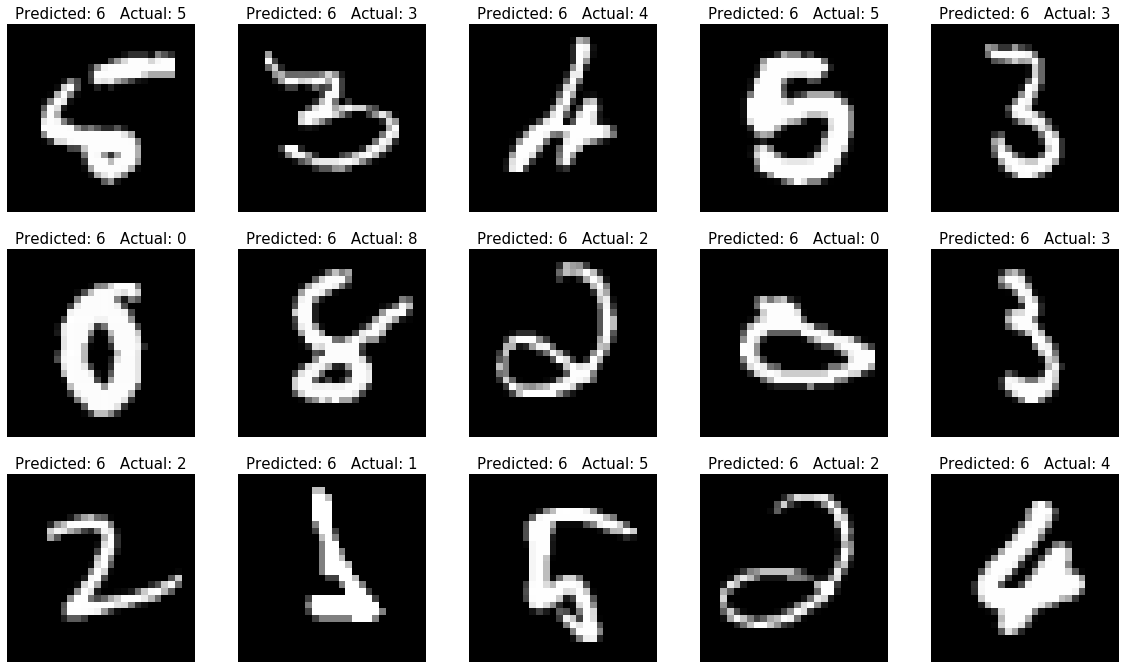

In [104]:
display_images_for_number(misclassified_images[0:150], 6)

A lot of letters that are thick and look similar to 6 seem to have been misclassified.

#### Misclassified images for the digit 7

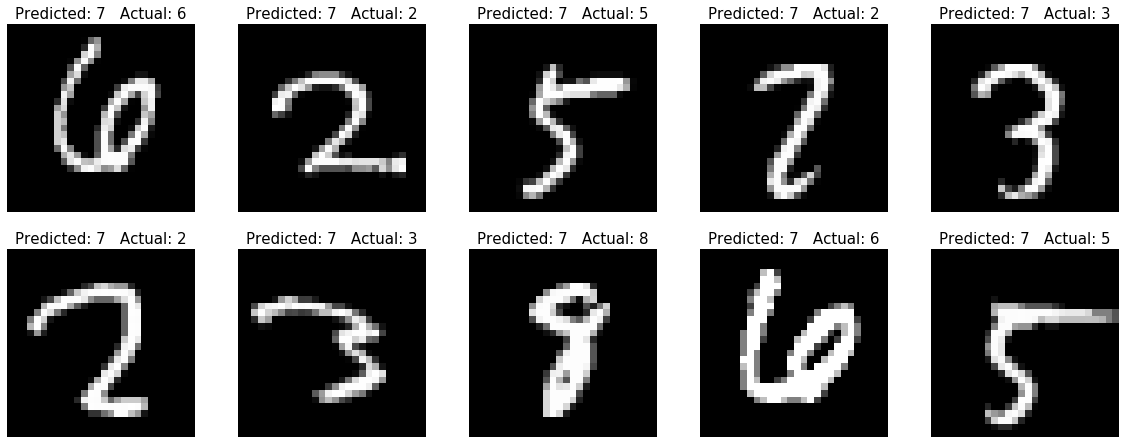

In [105]:
display_images_for_number(misclassified_images[0:100], 7)

It is interesting to see that 0, which has a clear distinction is being misclassified as 7. It could be because it looks like it is tilted by 90 degrees. May be we should train the model with images tilted in different directions.

#### Misclassified images for the digit 8

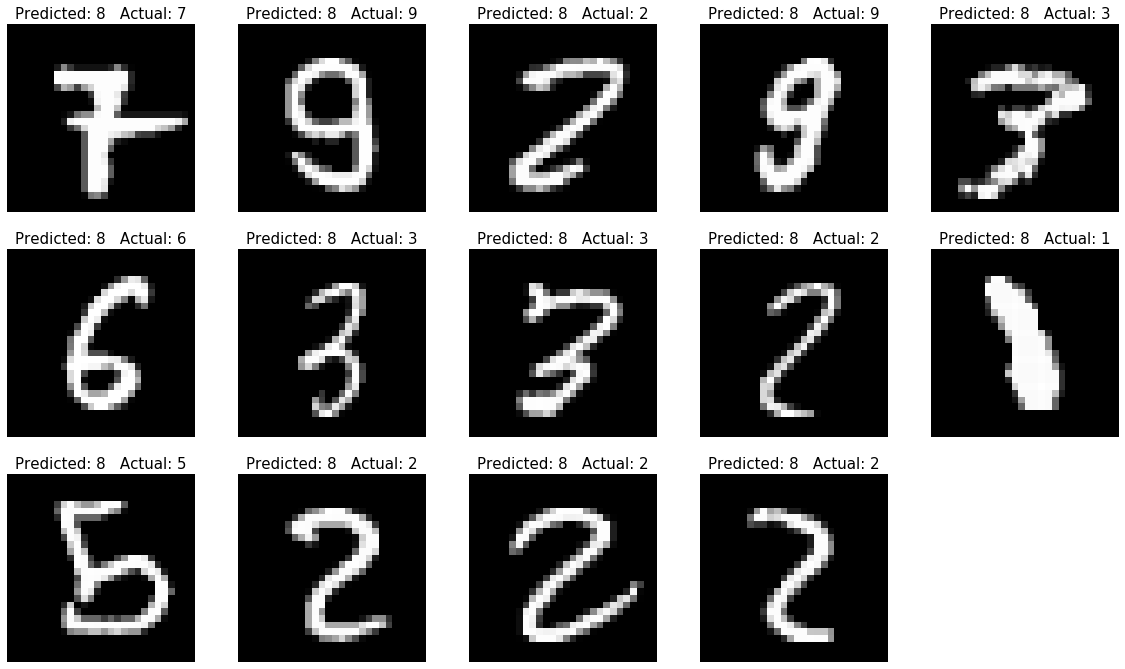

In [106]:
display_images_for_number(misclassified_images[0:100], 8)

It looks like all unclear handwritten digits are getting misclassified as 8

#### Misclassified images for the digit 9

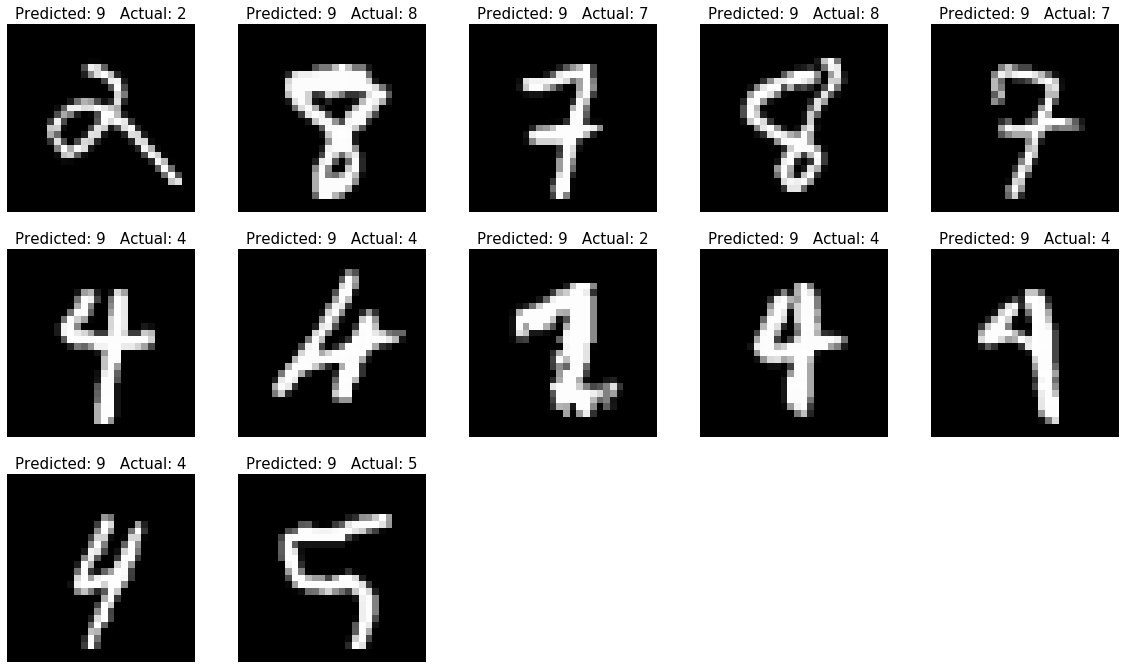

In [107]:
display_images_for_number(misclassified_images[0:100], 9)

Most of the 4's are getting misclassified as 9.

#### Misclassified images for the digit 0

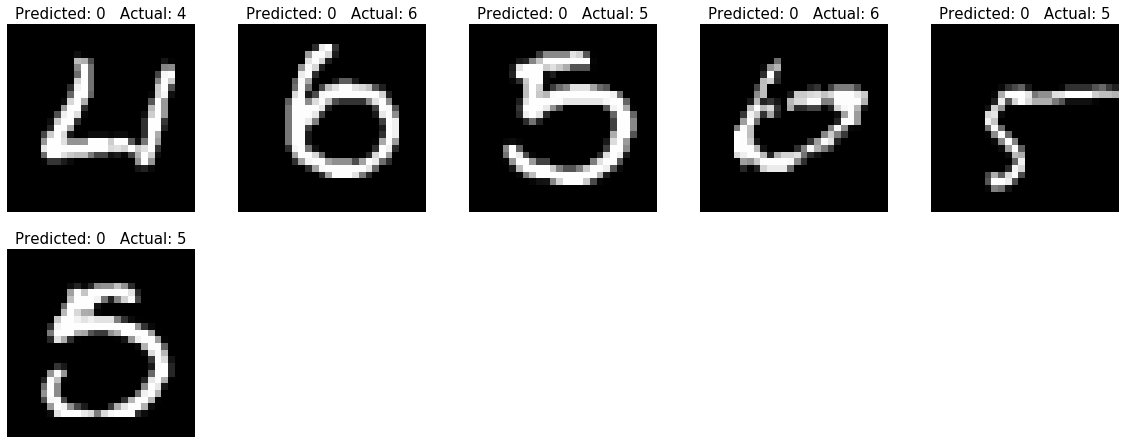

In [108]:
display_images_for_number(misclassified_images[0:100], 0)

Any number that resembles a circle or part of it resembles an incomplete circle is getting misclassified.It is strange that 4 is also getting misclassified.

To summarize, we could do the following to help improve the model:

1. Numbers that are incomplete/have gaps (for example 0 got predicted as 5 because it had a gap) seem to be wrongly classified.
2. Blurry handwritten (by probably students), slanty digits and in few cases very fat digits seem to get misclassified. Probably train model with more blurry images, deslanted and deskewed images.

## Testing the algorithm with synthetic data (WIP)

In [109]:
from sklearn.datasets import make_gaussian_quantiles
# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=3.,
                                 n_samples=1000, 
                                 n_classes=10, random_state=1)
X1 = pd.DataFrame(X1,columns=['x','y'])
y1 = pd.Series(y1)

clf = LogisticRegression(solver='lbfgs').fit(X1.x.values.reshape((-1,1)), X1.y)

ValueError: Unknown label type: 'continuous'

In [ ]:
X1.head()

In [ ]:
train_data

In [ ]:
clf = LogisticRegression(solver='lbfgs').fit(X1, y1)
predictions = clf.predict(test_data)

References:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
Confusion matrix: https://www.python-course.eu/confusion_matrix.php
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
Preprocessing
https://fsix.github.io/mnist/
Synthetic data generation:
https://towardsdatascience.com/synthetic-data-generation-a-must-have-skill-for-new-data-scientists-915896c0c1ae
https://towardsdatascience.com/do-you-need-synthetic-data-for-your-ai-project-e7ecc2072d6b
https://towardsdatascience.com/how-uber-uses-synthetic-data-to-speed-up-training-cc989c23ded4
